### Building a model to differentiate between noise and electrons from scratch

In this notebook, we will build a convolutional neural network to classify a signal as electron or noise. Therefore, we are facing a binary classification problem: electron or noise. This is the reason why we will have just one neuron in the output layer with sigmoidal activation.

First we import the data stored in a file called `eVSn.npz` composed of two variables: 'data' for the numpy arrays with energy or noise, and 'labels' where 1 stands for electron signal and 0 for noise.

* [First model: non scalated data](#First-model:-non-scalated-data)
* [Second model: scalated data and random tracks](#Second-model:-scalated-data-and-random-tracks)
* [Third model: scalated data, random tracks and dropout layers](#Third-model:-scalated-data,-random-tracks-and-dropout-layers)
* [Forth model: one more filter, no drop out](#Forth-model:-one-more-filter,-no-drop-out)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
loaded = np.load('/Users/Silvia/Desktop/TFM/e_VS_n/eVSn.npz')

X = loaded['data']
y = loaded['labels']

Once the data is loaded, we split it into train and test partitions with sklearn:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print(X_train.shape)

(3942, 201, 147)


In [4]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

print(X_train.shape)

(3942, 201, 147, 1)


### First model: non scalated data

Our network will be composed of a stack of alternate layers of `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. It is important to note that the depth of feature maps progressively increases as we move through the neural network (from 32 to 128) while the size of feature maps decreases (from 200x146 to 70x7).

As we are attacking a binary classification problem (electron or noise), we are going to finish the network with a single unit (a dense layer of size 1) and with a sigmoid activation. This unit will encode the probability that our network is looking at one class or another.

In [5]:
import keras
from keras import layers, models, optimizers

Using TensorFlow backend.


In [6]:
window_y, window_x = 201,147

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32,(2,2), activation='relu', input_shape=(window_y, window_x, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(units= 2050, activation='softmax'))
model.add(layers.Dense(units= 512, activation='softmax'))
model.add(layers.Dense(units= 1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 146, 32)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 73, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 14, 128)      

To compile, we will use the `RMSprop`(lr=1e-4) omptimizer. As we are facing the binary classification problem, we will use binary crossentropy as our loss function

In [8]:
model.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='binary_crossentropy', metrics=['acc'])

Now let's make the fit, where the input will be composed of X_train with the numpy arrays with energy and noise, and y_train with the labels for noise or energy. We are going to run 30 epochs and use a validation split of 0.2 of the total training data

In [9]:
model.fit(X_train, y_train, epochs= 30, validation_split = 0.2)

Train on 3153 samples, validate on 789 samples
Epoch 1/30
3153/3153 [==============================] - 78s 25ms/step - loss: 0.6931 - acc: 0.4954 - val_loss: 0.6930 - val_acc: 0.9594
Epoch 2/30
3153/3153 [==============================] - 76s 24ms/step - loss: 0.6929 - acc: 0.5874 - val_loss: 0.6928 - val_acc: 0.9911
Epoch 3/30
3153/3153 [==============================] - 80s 25ms/step - loss: 0.6927 - acc: 0.8325 - val_loss: 0.6926 - val_acc: 0.4968
Epoch 4/30
3153/3153 [==============================] - 82s 26ms/step - loss: 0.6925 - acc: 0.5281 - val_loss: 0.6923 - val_acc: 0.4968
Epoch 5/30
3153/3153 [==============================] - 81s 26ms/step - loss: 0.6921 - acc: 0.5046 - val_loss: 0.6920 - val_acc: 0.4968
Epoch 6/30
3153/3153 [==============================] - 82s 26ms/step - loss: 0.6918 - acc: 0.5046 - val_loss: 0.6916 - val_acc: 0.4968
Epoch 7/30
3153/3153 [==============================] - 76s 24ms/step - loss: 0.6914 - acc: 0.5046 - val_loss: 0.6913 - val_acc: 0.4968
E

We save the model just trainned:

In [10]:
model.save('model_electron_or_noise_v0.h5')

Finally, we evaluate our model using the test dataset:

In [11]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_test.shape)

(1314, 201, 147, 1)


In [12]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1314/1314 [==============================] - 10s 8ms/step
Accuracy with the model: 98.86%


Now we predict:

In [13]:
y_predicted = model.predict(X_test)

And here we plot some results:

In [14]:
import matplotlib.pylab as plt

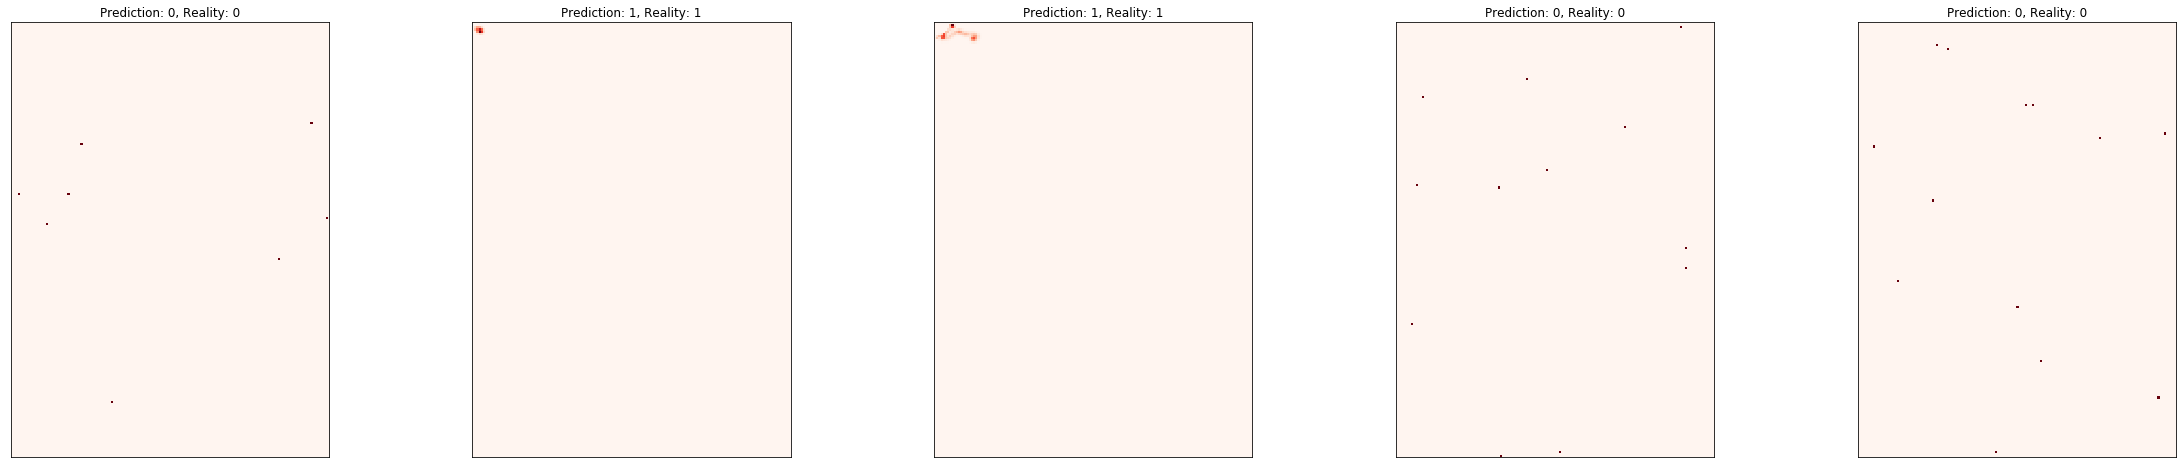

In [15]:
n = 5  # number of images to display
y_pred=0
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_test[i].reshape(window_y, window_x), cmap='Reds')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if y_predicted[i]>0.5:
        y_pred = 1
    else:
        y_pred = 0
    
    ax.set_title('Prediction: {}, Reality: {}'.format(y_pred, y_test[i]))
plt.show()

We can also plot the confusion matrix:

In [16]:
#https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.grid(b=False)
    plt.xlim(-0.5, 1.5)
    plt.ylim(1.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [17]:
y_predicted[np.where(y_predicted>=0.5)] = 1
y_predicted[np.where(y_predicted<0.5)] = 0

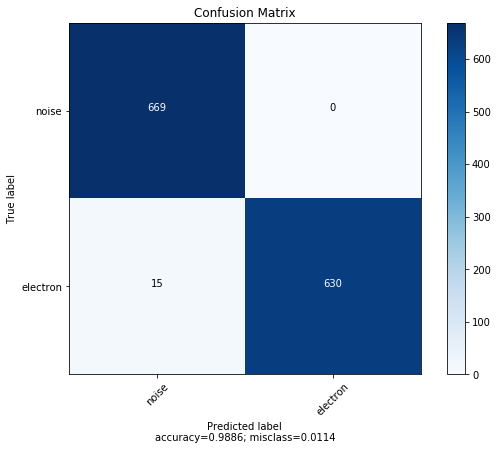

In [18]:
conf1 = confusion_matrix(y_test, y_predicted, labels = list([0,1]))

plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['noise', 'electron'],
                      title        = "Confusion Matrix")

Now we need to figure out if having all the tracks in the top left corner is important in order to decide whether the signal is an electron or noise:

In [19]:
window_y, window_x = (201, 147)

def padding_energy(array):
    #note that this function will be only applied to the energy of the particle, not the noise
    y, x = window_y, window_x  #y,x is the size of the maximum window
    y_image = array.shape[0]
    x_image = array.shape[1]
    reshaped = np.pad(array, ((y-y_image,0), (x-x_image, 0)),  constant_values=0)
    return reshaped

def crop(array):
    coords = np.argwhere(array)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped = array[x_min:x_max+1, y_min:y_max+1]
    return cropped

In [20]:
X_v1 = padding_energy(crop(X[1]))

X_v1 = X_v1.reshape((1, X_v1.shape[0], X_v1.shape[1], 1))

print("The prediction is", model.predict(X_v1), "and the true value", y[1])

The prediction is [[0.48880607]] and the true value 1


With the example we observe that the model predicted noise but the true label was electron signal, so we need to move all tracks randomly.

### Second model: scalated data and random tracks

As we observed, the position of the track influences the output of the network, so we moved all the tracks to random positions inside the maximum window:

In [21]:
loaded1 = np.load('/Users/Silvia/Desktop/TFM/e_VS_n/eVSn_1.npz')

X1 = loaded1['data']
y1 = loaded1['labels']

In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=0) #train, test partition

Normalizing data: normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

$mean = np.mean(X_{train}, axis=0)$

$std = np.std(X_{train}, axis=0)$

$X_{train} = (X_{train} -  mean[None, :]) / std[None, :]$

$X_{test} = (X_{test} -  mean[None, :]) / std[None, :]$

In [23]:
from sklearn import preprocessing

X_train1r = X_train1.reshape((X_train1.shape[0], X_train1.shape[1]* X_train1.shape[2]))
X_test1r = X_test1.reshape((X_test1.shape[0], X_test1.shape[1]* X_test1.shape[2]))

scaler1 = preprocessing.StandardScaler().fit(X_train1r)

X_train1r = scaler1.transform(X_train1r)

X_test1r = scaler1.transform(X_test1r)

In [24]:
print(X_train1r.shape)

(3942, 29547)


In [25]:
print(X_test1r.shape)

(1314, 29547)


Reshaping both training and testing images:

In [26]:
X_train1 = X_train1r.reshape((X_train1.shape[0], X_train1.shape[1], X_train1.shape[2], 1))

print(X_train1.shape)

(3942, 201, 147, 1)


In [27]:
X_test1 = X_test1r.reshape((X_test1.shape[0], X_test1.shape[1], X_test1.shape[2], 1))

print(X_test1.shape)

(1314, 201, 147, 1)


We can observe how the normalized data looks like:

Text(0.5, 1.0, 'Normalized data')

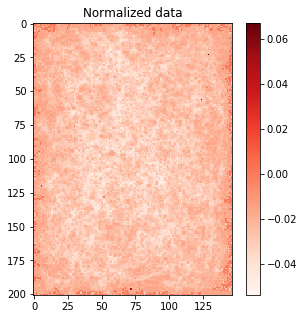

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(X_train1[0].reshape((X_train1.shape[1], X_train1.shape[2])), cmap='Reds')
plt.colorbar()
plt.title("Normalized data")

Text(0.5, 1.0, 'Non normalized data')

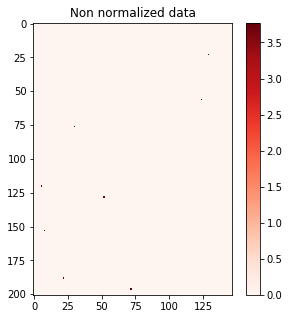

In [45]:
plt.figure(figsize=(5,5))
plt.imshow(X_train[0].reshape((X_train.shape[1], X_train.shape[2])), cmap='Reds')
plt.colorbar()
plt.title("Non normalized data")

We define the model:

In [46]:
model_v1 = models.Sequential()
model_v1.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))
model_v1.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v1.add(layers.MaxPooling2D((2,2)))

model_v1.add(layers.Flatten())
model_v1.add(layers.Dense(units= 2050, activation='relu'))
model_v1.add(layers.Dense(units= 512, activation='relu'))
model_v1.add(layers.Dense(units= 1, activation='sigmoid'))
model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 199, 145, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 72, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 14, 128)      

In [47]:
model_v1.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='binary_crossentropy', metrics=['acc'])

In [48]:
model_v1.fit(X_train1, y_train1, epochs= 30, validation_split = 0.2)

Train on 3153 samples, validate on 789 samples
Epoch 1/30
3153/3153 [==============================] - 88s 28ms/step - loss: 0.2328 - acc: 0.9112 - val_loss: 0.1964 - val_acc: 0.9518
Epoch 2/30
3153/3153 [==============================] - 83s 26ms/step - loss: 0.1377 - acc: 0.9597 - val_loss: 0.1072 - val_acc: 0.9645
Epoch 3/30
3153/3153 [==============================] - 84s 27ms/step - loss: 0.1341 - acc: 0.9667 - val_loss: 0.1238 - val_acc: 0.9658
Epoch 4/30
3153/3153 [==============================] - 87s 28ms/step - loss: 0.1067 - acc: 0.9702 - val_loss: 0.1023 - val_acc: 0.9721
Epoch 5/30
3153/3153 [==============================] - 85s 27ms/step - loss: 0.1004 - acc: 0.9743 - val_loss: 0.1193 - val_acc: 0.9670
Epoch 6/30
3153/3153 [==============================] - 84s 27ms/step - loss: 0.0920 - acc: 0.9762 - val_loss: 0.1102 - val_acc: 0.9747
Epoch 7/30
3153/3153 [==============================] - 81s 26ms/step - loss: 0.0824 - acc: 0.9772 - val_loss: 0.1093 - val_acc: 0.9721
E

In [49]:
model_v1.save('model_electron_or_noise_v1.h5')

In [50]:
loss, acc = model_v1.evaluate(X_test1, y_test1)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1314/1314 [==============================] - 9s 7ms/step
Accuracy with the model: 95.13%


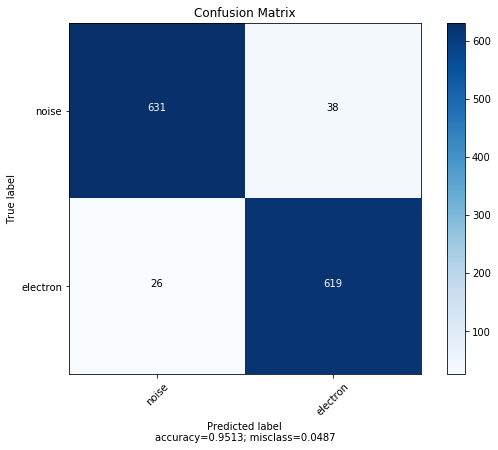

In [51]:
y_predicted1 = model_v1.predict(X_test1)

y_predicted1[np.where(y_predicted1>=0.5)] = 1
y_predicted1[np.where(y_predicted1<0.5)] = 0

conf11 = confusion_matrix(y_test, y_predicted1, labels = list([0,1]))

plot_confusion_matrix(cm           = conf11, 
                      normalize    = False,
                      target_names = ['noise', 'electron'],
                      title        = "Confusion Matrix")

### Third model: scalated data, random tracks and dropout layers
Now we will add some dropout layers to see if we can increase the accuracy of the model:

In [52]:
model_v2 = models.Sequential()
model_v2.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v2.add(layers.MaxPooling2D((2,2)))
model_v2.add(layers.Dropout(0.25))

model_v2.add(layers.Flatten())
model_v2.add(layers.Dropout(0.5))
model_v2.add(layers.Dense(units= 2050, activation='relu'))
model_v2.add(layers.Dense(units= 512, activation='relu'))
model_v2.add(layers.Dense(units= 1, activation='sigmoid'))
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 199, 145, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 99, 72, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 97, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 35, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 14, 128)      

In [53]:
model_v2.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='binary_crossentropy', metrics=['acc'])

In [54]:
model_v2.fit(X_train1, y_train1, epochs= 30, validation_split = 0.2)

Train on 3153 samples, validate on 789 samples
Epoch 1/30
3153/3153 [==============================] - 79s 25ms/step - loss: 0.2353 - acc: 0.9115 - val_loss: 0.1694 - val_acc: 0.9417
Epoch 2/30
3153/3153 [==============================] - 78s 25ms/step - loss: 0.1539 - acc: 0.9531 - val_loss: 0.1849 - val_acc: 0.9506
Epoch 3/30
3153/3153 [==============================] - 79s 25ms/step - loss: 0.1381 - acc: 0.9597 - val_loss: 0.1716 - val_acc: 0.9670
Epoch 4/30
3153/3153 [==============================] - 79s 25ms/step - loss: 0.1502 - acc: 0.9642 - val_loss: 0.1438 - val_acc: 0.9556
Epoch 5/30
3153/3153 [==============================] - 79s 25ms/step - loss: 0.1309 - acc: 0.9642 - val_loss: 0.5868 - val_acc: 0.9214
Epoch 6/30
3153/3153 [==============================] - 78s 25ms/step - loss: 0.1336 - acc: 0.9651 - val_loss: 0.3077 - val_acc: 0.9379
Epoch 7/30
3153/3153 [==============================] - 79s 25ms/step - loss: 0.1244 - acc: 0.9638 - val_loss: 0.2774 - val_acc: 0.9468
E

In [55]:
model_v2.save('model_electron_or_noise_v2.h5')

In [56]:
loss, acc = model_v2.evaluate(X_test1, y_test1)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1314/1314 [==============================] - 9s 7ms/step
Accuracy with the model: 93.23%


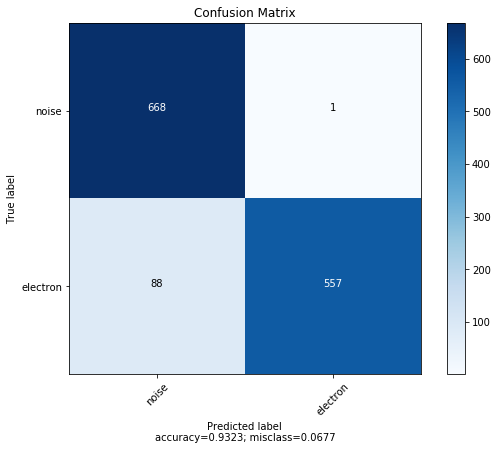

In [57]:
y_predicted2 = model_v2.predict(X_test1)

y_predicted2[np.where(y_predicted2>=0.5)] = 1
y_predicted2[np.where(y_predicted2<0.5)] = 0

conf2 = confusion_matrix(y_test, y_predicted2, labels = list([0,1]))

plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = ['noise', 'electron'],
                      title        = "Confusion Matrix")

Dropout layers didnt increase the accuracy!

### Forth model: one more filter, no drop out

We add another layer with one more filter, we do not include drop out layers and we just have two dnese layers.

In [60]:
model_v3 = models.Sequential()
model_v3.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(window_y, window_x, 1)))
model_v3.add(layers.MaxPooling2D((2,2)))
model_v3.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v3.add(layers.MaxPooling2D((2,2)))
model_v3.add(layers.Conv2D(64,(3,3), activation='relu'))
model_v3.add(layers.MaxPooling2D((2,2)))
model_v3.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v3.add(layers.MaxPooling2D((2,2)))
model_v3.add(layers.Conv2D(128,(3,3), activation='relu'))
model_v3.add(layers.MaxPooling2D((2,2)))

model_v3.add(layers.Flatten())
model_v3.add(layers.Dense(units= 512, activation='relu'))
model_v3.add(layers.Dense(units= 1, activation='sigmoid'))
model_v3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 199, 145, 32)      320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 99, 72, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 97, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 48, 35, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 46, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 23, 16, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 21, 14, 128)      

In [61]:
model_v3.compile(optimizer=optimizers.RMSprop(lr= 1e-4),loss='binary_crossentropy', metrics=['acc'])

In [62]:
model_v3.fit(X_train1, y_train1, epochs= 30, validation_split = 0.2)

Train on 3153 samples, validate on 789 samples
Epoch 1/30
3153/3153 [==============================] - 63s 20ms/step - loss: 0.4127 - acc: 0.8268 - val_loss: 0.1991 - val_acc: 0.9354
Epoch 2/30
3153/3153 [==============================] - 63s 20ms/step - loss: 0.2273 - acc: 0.9226 - val_loss: 0.1826 - val_acc: 0.9430
Epoch 3/30
3153/3153 [==============================] - 59s 19ms/step - loss: 0.2119 - acc: 0.9293 - val_loss: 0.1735 - val_acc: 0.9480
Epoch 4/30
3153/3153 [==============================] - 59s 19ms/step - loss: 0.2041 - acc: 0.9324 - val_loss: 0.1698 - val_acc: 0.9518
Epoch 5/30
3153/3153 [==============================] - 60s 19ms/step - loss: 0.1983 - acc: 0.9331 - val_loss: 0.1636 - val_acc: 0.9518
Epoch 6/30
3153/3153 [==============================] - 60s 19ms/step - loss: 0.1878 - acc: 0.9366 - val_loss: 0.1703 - val_acc: 0.9518
Epoch 7/30
3153/3153 [==============================] - 60s 19ms/step - loss: 0.1823 - acc: 0.9372 - val_loss: 0.1590 - val_acc: 0.9531
E

In [63]:
model_v3.save('model_electron_or_noise_v3.h5')

In [64]:
loss, acc = model_v3.evaluate(X_test1, y_test1)
print('Accuracy with the model: {:5.2f}%'.format(100*acc))

1314/1314 [==============================] - 8s 6ms/step
Accuracy with the model: 92.16%


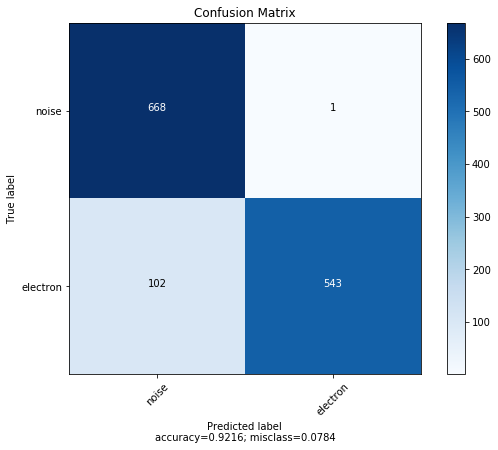

In [65]:
y_predicted3 = model_v3.predict(X_test1)

y_predicted3[np.where(y_predicted3>=0.5)] = 1
y_predicted3[np.where(y_predicted3<0.5)] = 0

conf3 = confusion_matrix(y_test, y_predicted3, labels = list([0,1]))

plot_confusion_matrix(cm           = conf3, 
                      normalize    = False,
                      target_names = ['noise', 'electron'],
                      title        = "Confusion Matrix")